# Model training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')

## Training

In [3]:
seed = 33
batch_size = 16
MAX_LEN = 256

### Sets

In [4]:
from sklearn.model_selection import train_test_split

def data_split(df_train, n_samples, test_size, val_size):
    if n_samples != 0:
        df_train = df_train.sample(n=n_samples, random_state = seed)
    
    
    # Label encoding
    new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
    df_train = df_train.replace(new_label)
    df_train = df_train.rename(columns = {"discourse_effectiveness": "label"})
    # One-hot encode and set columns in order
#     y = pd.get_dummies(df_train['discourse_effectiveness'])
#     y = y[['Ineffective','Adequate','Effective']]

    X = df_train['input']
    y = df_train['label']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = seed)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = val_size, random_state = seed)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
import tensorflow as tf
from transformers import TFBertModel
import transformers

In [6]:
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [7]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('../input/huggingface-bert-variants/bert-base-cased/bert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

## Data preparation

In [8]:
sep = tokenizer.sep_token
sep

'[SEP]'

In [9]:
# df['inputs'] = df.discourse_type + sep +df.discourse_text?????
df_train['input'] = sep +df_train.discourse_text

In [10]:
n_samples = 0 # 0 is for whole dataset
test_size = 0.10
val_size = 0.10

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df_train, n_samples=n_samples, test_size = test_size, val_size = val_size)

In [11]:
X_train = bert_encode(X_train.astype(str), tokenizer)
X_val = bert_encode(X_val.astype(str), tokenizer)
X_test = bert_encode(X_test.astype(str), tokenizer)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [12]:
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

y_train: (29779,), y_val: (3309,), y_test: (3677,)


In [13]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(32768)
    .batch(batch_size)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

2022-06-08 11:26:29.954252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:26:29.955877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:26:29.956840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 11:26:29.959288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Model

In [14]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

lr = 0.00001

input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="token_type_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_model = (TFBertModel.from_pretrained('../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'))
sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

clf_output = sequence_output[:, 0, :]
clf_output = Dropout(0.3)(clf_output)
clf_output = Dense(16, activation='softmax')(clf_output)
out = Dense(3, activation='softmax')(clf_output)
    
model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
model.compile(Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimiz

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

In [16]:
epochs = 15

history = model.fit(
    train_dataset,
    steps_per_epoch=200,
    validation_data=valid_dataset,
    epochs=epochs
)

Epoch 1/15


2022-06-08 11:27:04.768663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


200/200 [==============================] - 162s 716ms/step - loss: 0.9964 - accuracy: 0.5566 - val_loss: 0.9916 - val_accuracy: 0.5579
Epoch 2/15
200/200 [==============================] - 140s 702ms/step - loss: 0.9825 - accuracy: 0.5731 - val_loss: 0.9750 - val_accuracy: 0.5579
Epoch 3/15
200/200 [==============================] - 140s 702ms/step - loss: 0.9652 - accuracy: 0.5803 - val_loss: 0.9541 - val_accuracy: 0.5672
Epoch 4/15
200/200 [==============================] - 140s 700ms/step - loss: 0.9537 - accuracy: 0.6044 - val_loss: 0.9379 - val_accuracy: 0.6331
Epoch 5/15
200/200 [==============================] - 140s 701ms/step - loss: 0.9344 - accuracy: 0.6281 - val_loss: 0.9308 - val_accuracy: 0.6392
Epoch 6/15
200/200 [==============================] - 140s 699ms/step - loss: 0.9266 - accuracy: 0.6369 - val_loss: 0.9299 - val_accuracy: 0.6228
Epoch 7/15
200/200 [==============================] - 139s 697ms/step - loss: 0.9210 - accuracy: 0.6447 - val_loss: 0.9201 - val_accura

In [17]:
model.evaluate(test_dataset)

230/230 [==============================] - 43s 187ms/step - loss: 0.8954 - accuracy: 0.6655


[0.8953918218612671, 0.6654881834983826]

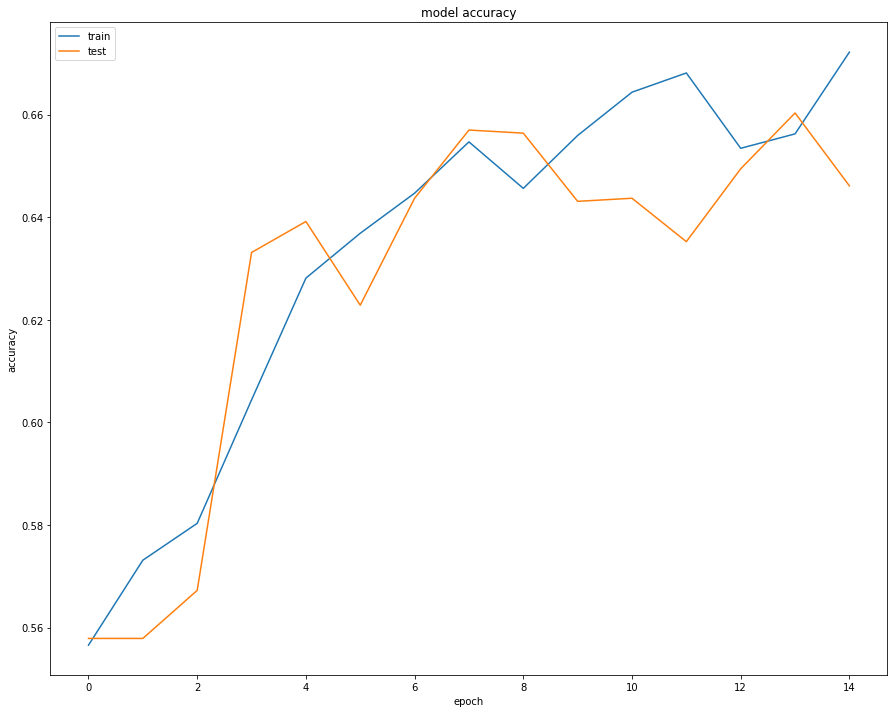

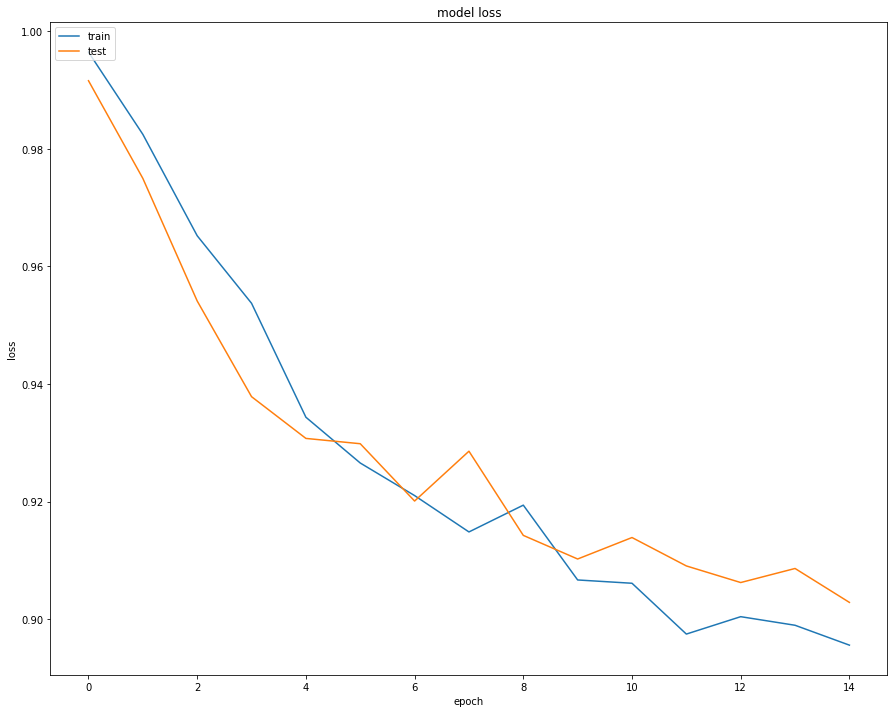

In [18]:
figsize = (15, 12)

plt.figure(figsize=figsize)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=figsize)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission

In [19]:
df_test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df_test.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [20]:
pd.read_csv('../input/feedback-prize-effectiveness/sample_submission.csv').head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [21]:
df_test['input'] = df_test.discourse_type + sep + df_test.discourse_text
test_text = bert_encode(df_test.input.astype(str), tokenizer)

In [22]:
pred = model.predict(test_text, verbose=1)
pred

1/1 [==============================] - 3s 3s/step


array([[0.17029339, 0.42542726, 0.40427938],
       [0.19427371, 0.49555874, 0.3101676 ],
       [0.19772811, 0.506302  , 0.29596993],
       [0.19816115, 0.5067588 , 0.29508007],
       [0.19939877, 0.50639576, 0.29420546],
       [0.17296673, 0.41609564, 0.41093758],
       [0.17361307, 0.4139586 , 0.41242835],
       [0.19808915, 0.5068246 , 0.2950862 ],
       [0.17182192, 0.4197974 , 0.40838072],
       [0.17088102, 0.42699045, 0.4021286 ]], dtype=float32)

In [23]:
df_test['Ineffective'] = pred[:,0]
df_test['Adequate'] = pred[:,1]
df_test['Effective'] = pred[:,2]
df_test.drop(['essay_id','discourse_text','discourse_type', 'input'], axis=1, inplace=True)

In [24]:
df_test.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.170293,0.425427,0.404279
1,5a88900e7dc1,0.194274,0.495559,0.310168
2,9790d835736b,0.197728,0.506302,0.295970
3,75ce6d68b67b,0.198161,0.506759,0.295080
4,93578d946723,0.199399,0.506396,0.294205


In [25]:
df_test.to_csv("submission.csv", index=False)